['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']
Points 

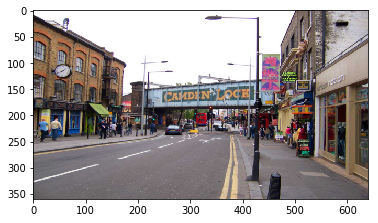

In [77]:
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
import csv
import numpy as np
from scipy import misc

%matplotlib inline

# the backgorunds
background_images = []
BACKGROUND_DIR = './backgrounds/'
BACKGROUND_X = 640
BACKGROUND_Y = 360


for fname in listdir(BACKGROUND_DIR):
    img = misc.imresize(misc.imread(BACKGROUND_DIR + fname), (BACKGROUND_Y, BACKGROUND_X))
    background_images.append(img)
    
plt.imshow(background_images[1])


# the imageset
df = pd.DataFrame()

PATH = 'GTSRB/Final_Training/Images'
for label_dir in listdir(PATH):
    try: label_dir.index('000')
    except ValueError: continue
    my_path = '{}/{}/'.format(PATH, label_dir)
    df_csv = pd.read_csv('{}/GT-{}.csv'.format(my_path, label_dir), sep=';')
    df_csv['Path'] = my_path
    df = pd.concat([df, df_csv])
    

label_names = []
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        label_names.append(row[1])

del label_names[0]
class_id_set = range(len(label_names))        

print (label_names)
print ('Points in set:', len(df))


Filename                       00000_00000.ppm
Width                                       29
Height                                      30
Roi.X1                                       5
Roi.Y1                                       6
Roi.X2                                      24
Roi.Y2                                      25
ClassId                                      0
Path        GTSRB/Final_Training/Images/00000/
Name: 0, dtype: object


(array([  2.01580000e+04,   1.10050000e+04,   4.37200000e+03,
          1.93700000e+03,   1.01400000e+03,   4.31000000e+02,
          1.91000000e+02,   6.90000000e+01,   2.60000000e+01,
          6.00000000e+00]),
 array([  20. ,   38.5,   57. ,   75.5,   94. ,  112.5,  131. ,  149.5,
         168. ,  186.5,  205. ]),
 <a list of 10 Patch objects>)

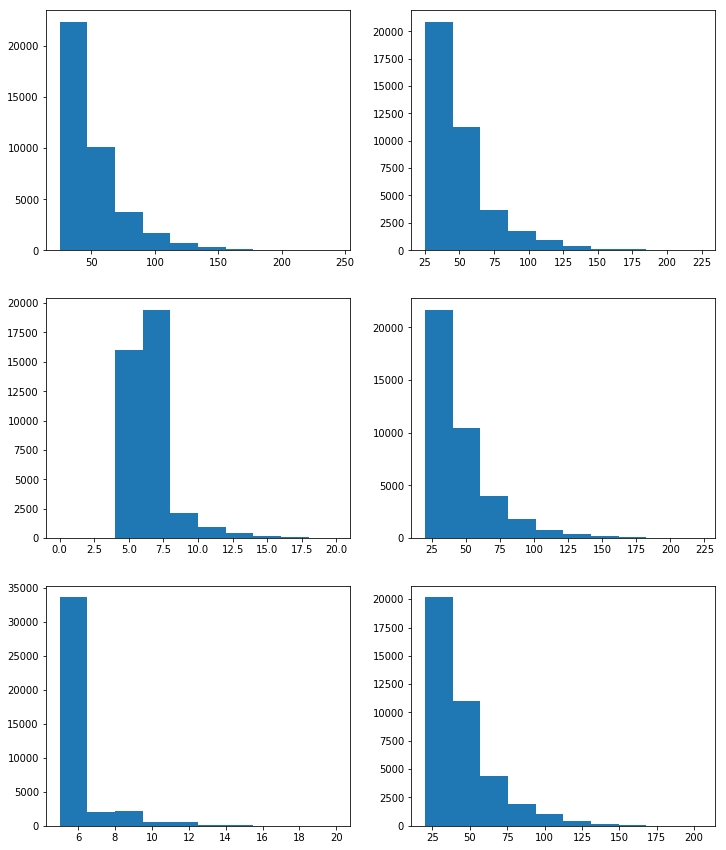

In [78]:
print (df.iloc[0])
plt.figure(figsize=(12,15))

plt.subplot(3,2,1)
plt.hist(df['Width'].values)
plt.subplot(3,2,2)
plt.hist(df['Height'].values)
plt.subplot(3,2,3)
plt.hist(df['Roi.X1'].values)
plt.subplot(3,2,4)
plt.hist(df['Roi.X2'].values)
plt.subplot(3,2,5)
plt.hist(df['Roi.Y1'].values)
plt.subplot(3,2,6)
plt.hist(df['Roi.Y2'].values)

In [251]:
## generating the training dataset
import random
from math import *
# generating the traffic sign on backgound dataset
df_selected = df[df['Width'] > 50]
df_selected = df_selected.sample(frac=1)

n = 1000

# X - list of the train images
X_list = []
#y1_list, y2_list, x1_list, x2_list =[], [], [], []
# x1, y1, x2, y2 ... list of the sign coords
Y_list = []

for i in range(n):
    sign_img = misc.imread(df_selected.iloc[i]['Path'] + df_selected.iloc[i]['Filename'])
    background = np.copy(background_images[i % len(background_images) ])
    
    sign_y, sign_x = sign_img.shape[0], sign_img.shape[1]
    pos_y1, pos_x1 = random.randint(0, BACKGROUND_Y - sign_y -1 ), random.randint(0, BACKGROUND_X - sign_x - 1)

    pos_y2 = pos_y1 + sign_y
    pos_x2 = pos_x1 + sign_x

    Y_list.append([pos_y1 + df_selected.iloc[i]['Roi.Y1'],
                  pos_x1 + df_selected.iloc[i]['Roi.X1'],
                  pos_y2 - (sign_y - df_selected.iloc[i]['Roi.Y2']),
                  pos_x2 - (sign_x - df_selected.iloc[i]['Roi.X2'])]
                 )
                  
        
    #y1_list.append(pos_y1 + df_selected.iloc[i]['Roi.Y1'])
    #y2_list.append(pos_y2 - (sign_y - df_selected.iloc[i]['Roi.Y2']))
    #x1_list.append(pos_x1 + df_selected.iloc[i]['Roi.X1'])
    #x2_list.append(pos_x2 - (sign_x - df_selected.iloc[i]['Roi.X2']))    
    
    generated = background
    generated[pos_y1 : pos_y2, pos_x1 : pos_x2, 0:3] = sign_img
    X_list.append(generated)

X_list = np.array(X_list)
Y_list = np.array(Y_list)

    
    

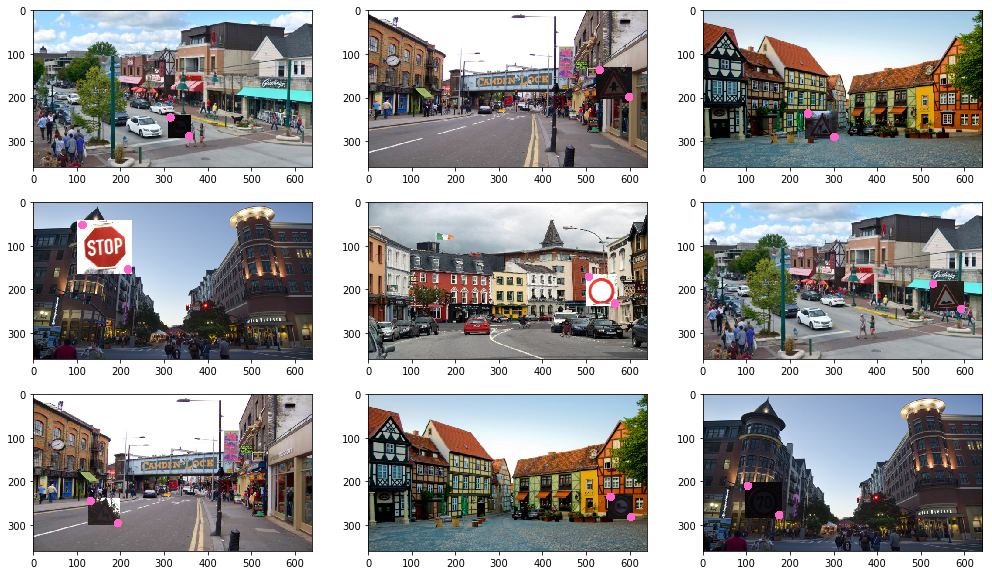

In [252]:
from skimage import draw
plt.figure(figsize=(17,10))
n = 3
m = 3
for j in range(n):
    for k in range(n):
        i = j * m + k
        plt.subplot(n, m, i+1)
        img = X_list[i]

        rr, cc = draw.circle(Y_list[i][0], Y_list[i][1], 10)
        img[:,:,0][rr,cc] = 255
        img[:,:,1][rr,cc] = 100
        img[:,:,2][rr,cc] = 200

        rr, cc = draw.circle(Y_list[i][2], Y_list[i][3], 10)
        img[:,:,0][rr,cc] = 255
        img[:,:,1][rr,cc] = 100
        img[:,:,2][rr,cc] = 200
    
    
        plt.imshow(img)

In [253]:
TEST_PROP = 0.2

X_train = X_list[0:int(len(X_list) * (1-TEST_PROP))] 
X_test = X_list[int(len(X_list) * (1-TEST_PROP)):]

Y_train = Y_list[0:int(len(X_list) * (1-TEST_PROP))] 
Y_test = Y_list[int(len(X_list) * (1-TEST_PROP)):]

print ('X train/test', len(X_train), len(X_test))
print ('Y train/test', len(Y_train), len(Y_test))


X train/test 800 200
Y train/test 800 200


In [254]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

model = Sequential()
model.add(Convolution2D(16, 3, 3, input_shape=(BACKGROUND_Y, BACKGROUND_X, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Activation('relu'))

model.add(Convolution2D(32, 3, 3, input_shape=(BACKGROUND_Y, BACKGROUND_X, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3, input_shape=(BACKGROUND_Y, BACKGROUND_X, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(1000))
model.add(Dense(1000))
model.add(Dense(4))
print (model.output)

Tensor("add_22:0", shape=(?, 4), dtype=float32)


In [256]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [257]:
model.fit(X_train, Y_train)

Epoch 1/10


KeyboardInterrupt: 